In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Load data
kiwo_url = '../../Data/kiwo.csv'
umsatz_url = '../../Data/train.csv'
wetter_url = '../../Data/wetter.csv'
test_url = '../../Data/test.csv'

df_kiwo = pd.read_csv(kiwo_url)
df_umsatz = pd.read_csv(umsatz_url)
df_wetter = pd.read_csv(wetter_url)
df_test = pd.read_csv(test_url)

# Merge data
df_train = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')
df_train = pd.merge(df_train, df_kiwo, on='Datum', how='left')
df_test = pd.merge(df_test, df_wetter, on='Datum', how='left')
df_test = pd.merge(df_test, df_kiwo, on='Datum', how='left')

# df_train.head()
# df_test.head()


In [18]:
# Function to prepare data
def prepare_data(data):
    data['Datum'] = pd.to_datetime(data['Datum'])
    data['DayOfWeek'] = data['Datum'].dt.dayofweek
    data['Month'] = data['Datum'].dt.month
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(float)
    data['KielerWoche'] = data['KielerWoche'].fillna(0).astype(float)
    
    # Replace NaNs using KNN Imputer
    numerical_cols = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode', 'IsWeekend']
    knn_imputer = KNNImputer(n_neighbors=5)
    data[numerical_cols] = knn_imputer.fit_transform(data[numerical_cols])
    
    # One-hot encode categorical features
    warengruppe_dummies = pd.get_dummies(data['Warengruppe'], prefix='Warengruppe')
    day_dummies = pd.get_dummies(data['DayOfWeek'], prefix='Day')
    month_dummies = pd.get_dummies(data['Month'], prefix='Month')
    
    # Combine all features
    feature_df = pd.concat([data[numerical_cols], warengruppe_dummies, day_dummies, month_dummies], axis=1)
    return feature_df

# Prepare datasets
X_train = prepare_data(df_train)
y_train = df_train['Umsatz']
X_test = prepare_data(df_test)

X_train.head()
# df_test.head()

,Temperatur,Windgeschwindigkeit,Bewoelkung,Wettercode,IsWeekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,17.8375,15.0,6.0,20.0,0.0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,17.3125,10.0,3.0,0.0,0.0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,21.0750,6.0,7.0,61.0,0.0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,18.8500,7.0,7.0,20.0,0.0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,19.9750,12.0,5.0,63.0,0.0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [19]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split data into training and validation sets

# OLD split:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# NEW split: why random_state? --> Alternative:
# Determine the split point
split_point = int(len(X_train) * 0.8)

# Split the data
X_train = X_train[:split_point]
y_train = y_train[:split_point]
X_val = X_train[split_point:]
y_val = y_train[split_point:]


Epoch 1/5


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 38845.9219 - mean_absolute_percentage_error: 75.1440 - learning_rate: 0.0100
Epoch 2/5
 96/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4642.7783 - mean_absolute_percentage_error: 26.4616

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_percentage_error
  current = self.get_monitor_value(logs)
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4313.7812 - mean_absolute_percentage_error: 25.8271 - learning_rate: 0.0099
Epoch 3/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3245.2454 - mean_absolute_percentage_error: 22.7397 - learning_rate: 0.0098
Epoch 4/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3341.1294 - mean_absolute_percentage_error: 21.9065 - learning_rate: 0.0097
Epoch 5/5
 94/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3543.8962 - mean_absolute_percentage_error: 23.3446

2025-01-07 15:51:42.187845: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3367.0767 - mean_absolute_percentage_error: 22.7667 - learning_rate: 0.0096


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        16,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,755 (190.45 KB)

 Trainable params: 16,251 (63.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,504 (126.97 KB)

None


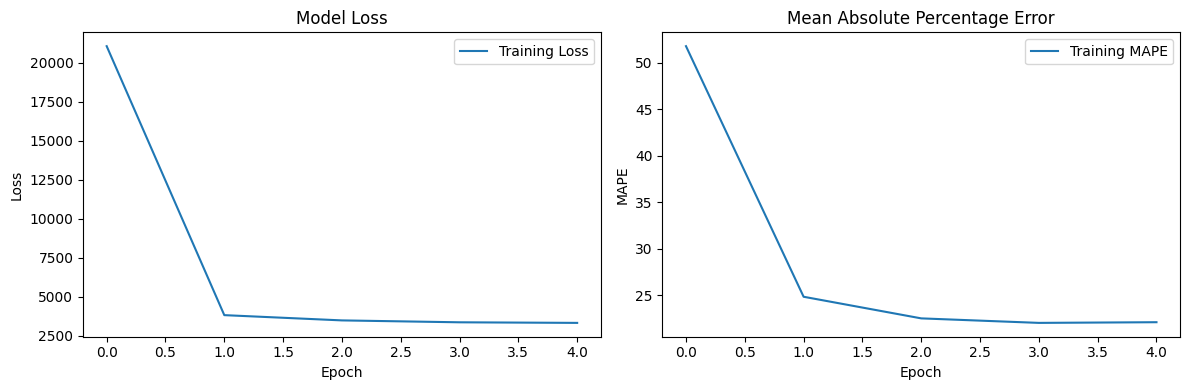

Final Training MAPE: 22.11%


ValueError: math domain error

In [20]:
# # Reshape for LSTM (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Learning rate scheduler function
def lr_schedule(epoch, lr):
    initial_lr = 0.01  # Start with this learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 10  # Epochs after which to decay
    return initial_lr * np.exp(-decay_rate * (epoch / decay_steps))

# Define callbacks
# EarlyStopping: stop training if 'val_loss' is not improving for 40 epochs --> restore weights of the best-performing model
# ModelCheckpoint: will save the best-performing model (based on the validation loss) to the file 'best_model.keras'
# LearningRateScheduler: This callback will apply the custom learning rate schedule defined in the lr_schedule function
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Model with proper input layer
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(50, activation='relu')(inputs)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mean_absolute_percentage_error']
)


# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=5, #was 150
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

print(model.summary())

# Plot training history
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.plot(history.history['mean_absolute_percentage_error'], label='Train MAPE')
# plt.plot(history.history['val_mean_absolute_percentage_error'], label='Val MAPE')
# plt.xlabel('Epoch')
# plt.ylabel('Loss/Metric')
# plt.legend()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Plot training history
plt.figure(figsize=(12, 4))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAPE subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_percentage_error'], label='Training MAPE')
if 'val_mean_absolute_percentage_error' in history.history:
    plt.plot(history.history['val_mean_absolute_percentage_error'], label='Validation MAPE')
plt.title('Mean Absolute Percentage Error')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
final_train_mape = history.history['mean_absolute_percentage_error'][-1]
print(f'Final Training MAPE: {final_train_mape:.2f}%')

# # Load the best model
# model.load_weights('best_model.keras')

# # Evaluate on validation set
# val_predictions = model.predict(X_val).flatten()
# val_mape = tf.keras.metrics.MeanAbsolutePercentageError()(y_val, val_predictions).numpy()
# print(f'MAPE on validation set: {val_mape:.2f}%')

# # Make predictions on test set and save results
# test_predictions = model.predict(X_test).flatten()
# df_test['Predicted_Umsatz'] = test_predictions
# df_test.to_csv('predicted_test.csv', index=False)

# Load the best model
model.load_weights('best_model.keras')

# Evaluate on validation set
val_predictions = model.predict(X_val).flatten()
val_mape = tf.keras.metrics.MeanAbsolutePercentageError()(y_val, val_predictions).numpy()
print(f'MAPE on validation set: {val_mape:.2f}%')

# Make predictions on test set and save results
test_predictions = model.predict(X_test).flatten()
df_test['Predicted_Umsatz'] = test_predictions
df_test.to_csv('predicted_test.csv', index=False)